In [1]:
import mxnet as mx
from mxnet import gluon as g
from mxnet import nd
import numpy as np
from mxnet import autograd as ag
from matplotlib import pyplot as plt
import os
import time

In [2]:
ctx = mx.gpu()

In [3]:
batch_size = 96
height = 32
width = 7*height

In [4]:
data_iter = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','train.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

data_iter_val = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','val.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

In [5]:
class autoencoder(g.nn.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():
            self.encodercnn = g.nn.HybridSequential('encoder_cnn_')
            with self.encodercnn.name_scope():
                self.encodercnn.add(g.nn.Conv2D(64, 3, strides=1, padding=1, activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
                self.encodercnn.add(g.nn.Conv2D(128, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=(2,1)))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=(2,1)))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=(2,1)))
                self.encodercnn.add(g.nn.Conv2D(512, 1, strides=1, padding=0,activation='relu'))
                
            self.encoderrnn = g.rnn.SequentialRNNCell('encoder_rnn_')
            with self.encoderrnn.name_scope():
                self.encoderrnn.add(g.rnn.LSTMCell(512))
                self.encoderrnn.add(g.rnn.LSTMCell(512))
                #self.encoderrnn.add(g.rnn.LSTMCell(512))
            
            #self.intermediate_nn = g.nn.Dense(512)
            
            self.decoderrnn = g.rnn.SequentialRNNCell('decoder_rnn_')
            with self.decoderrnn.name_scope():
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                #self.decoderrnn.add(g.rnn.LSTMCell(512))
            
            self.decodercnn = g.nn.HybridSequential('decoder_cnn_')
            with self.decodercnn.name_scope():
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 1, strides=1, padding=0,activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(128, 3, strides=1, padding=1,activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(64, 3, strides=1, padding=1, activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(3, 3, strides=1, padding=1, activation='tanh'))
        
    def forward(self, x):
        # encoder cnn
        x = self.encodercnn(x)
        
        # encoder rnn
        status = self.encoderrnn.begin_state(batch_size=batch_size,ctx=ctx)
        for i in range(x.shape[3]):
            cvector, status = self.encoderrnn(nd.flatten(x[:,:,:,i]), status)
            if i == 0:
                outputs_o = mx.nd.expand_dims(cvector, axis=2)
            else:
                outputs_o = mx.nd.concat(outputs_o,mx.nd.expand_dims(cvector,axis=2),dim=2)
        #cvector = self.intermediate_nn(cvector)
        
        # decoder rnn
        status = self.decoderrnn.begin_state(batch_size=batch_size,ctx=ctx)
        for i in range(x.shape[3]):
            cvector, status = self.decoderrnn(nd.flatten(outputs_o[:,:,i]), status)
            if i == 0:
                outputs = mx.nd.expand_dims(cvector, axis=2)
            else:
                outputs = mx.nd.concat(outputs,mx.nd.expand_dims(cvector,axis=2),dim=2)
        xs = mx.nd.Reshape(outputs,(x.shape[0],x.shape[1],1,x.shape[3]))
        
        # decoder cnn
        for i in range(len(self.decodercnn)):
            xs = self.decodercnn[i](xs)
            if (i == 0):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=2, width=112)
            elif (i == 2):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=4, width=112)
            elif (i == 4):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=8, width=112)
            elif (i == 5):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=16, width=112)
            elif (i == 6):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=32, width=224)
        return xs*4

In [6]:
model = autoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
for batch in data_iter:
    batch
    break
print(model(batch.data[0].as_in_context(ctx)).shape)
model.save_parameters("process/ae_*.params")

(96L, 3L, 32L, 224L)


In [7]:
criterion = g.loss.L2Loss()

### Optimization

In [8]:
train_metric = mx.metric.MAE()
val_metric = mx.metric.MAE()
#for opt in sorted({'Adam','RMSProp','SGD'}):
for opt in sorted({'Adam'}):
#    for lr in sorted({0.1,0.01,0.001},reverse=True):
    for lr in sorted({0.001},reverse=True):
        start_epoch = 0
        epochs = 5
        model.load_parameters("process/ae_*.params")
        optimizer = g.Trainer(model.collect_params(), opt, {'learning_rate': lr, 'wd': 1e-5})
        print('### Optimizer: %s ### Learning Rate: %.3f' % (opt,lr))
        val_val_check = np.inf
        for epoch in range(start_epoch, epochs):
            # train
            train_loss = 0
            train_metric.reset()
            data_iter.reset()
            tic = time.time()
            counter = 0
            for batch in data_iter:
                with ag.record():
                    x = batch.data[0].as_in_context(ctx)
                    y = model(x)
                    loss = criterion(x,y)
                    loss.backward()
                    train_loss += mx.nd.sum(loss).asscalar()
                optimizer.step(batch_size, ignore_stale_grad=True)
                train_metric.update(x, y)
                counter += 1
            toc = time.time()
            name_train, val_train = train_metric.get()
            # validation
            val_loss = 0
            val_metric.reset()
            data_iter_val.reset()
            for batch in data_iter_val:
                x = batch.data[0].as_in_context(ctx)
                y = model(x)
                loss = criterion(x,y)
                val_loss += mx.nd.sum(loss).asscalar()
                val_metric.update(x, y)
            name_val, val_val = val_metric.get()
            print('epoch:%3d;\t train:%.6e;%.6e;val:%.6e;%.6e;\t Speed:%d'
                  %(epoch, train_loss/(counter*batch_size), val_train, val_loss/(counter*batch_size), val_val, (counter*batch_size)/(toc-tic)))
            if val_val < val_val_check:
                model.save_parameters('process/ae_*.params')
                val_val_check = val_val

### Optimizer: Adam ### Learning Rate: 0.001
epoch:  0;	 train:1.594784e-01;2.423763e-01;val:4.036975e-03;1.311573e-01;	 Speed:89
epoch:  1;	 train:4.613708e-02;1.165848e-01;val:2.002132e-03;7.908150e-02;	 Speed:89
epoch:  2;	 train:2.983926e-02;9.150582e-02;val:1.930017e-03;1.312125e-01;	 Speed:89
epoch:  3;	 train:2.408752e-02;8.550228e-02;val:1.482045e-03;8.038331e-02;	 Speed:89
epoch:  4;	 train:2.192792e-02;7.845191e-02;val:1.021223e-03;5.371031e-02;	 Speed:89


### Visualization

In [9]:
model.load_parameters("process/ae_*.params")
for batch in data_iter:
    x = batch.data[0].as_in_context(ctx)
    y = model(x)
    break

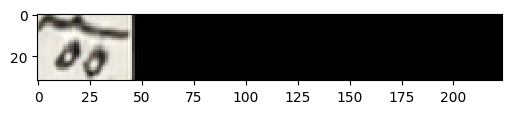

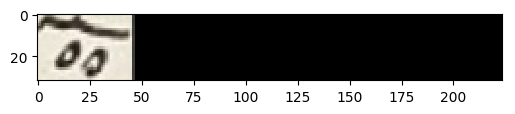

In [10]:
from random import randint
whichIm = randint(0,batch_size)
val_image = y[whichIm,:,:,:].as_in_context(mx.cpu())
val_image = val_image.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
val_image = (val_image * 255).clip(0, 255)
val_image = val_image.asnumpy()
val_image = val_image.astype(np.uint8)
plt.rcParams["figure.dpi"] = 100
plt.imshow(val_image)
plt.savefig('/home/mcy/Dropbox/val.png')
plt.show()
org = x[whichIm,:,:,:].as_in_context(mx.cpu())
org = org.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
org = (org * 255).clip(0, 255)
org = org.asnumpy()
org = org.astype(np.uint8)
plt.imshow(org)
plt.savefig('/home/mcy/Dropbox/org.png')
plt.show()